In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


# Week 5

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from tabulate import tabulate

In [2]:
A = np.arange(0,16).reshape((4,4)) # making square matrix
A[1:-1,1:-1] = np.arange(100,500,100).reshape((2,2))     # in numpy slices can be assigned to 
A

array([[  0,   1,   2,   3],
       [  4, 100, 200,   7],
       [  8, 300, 400,  11],
       [ 12,  13,  14,  15]])

In [3]:
N = 6
L = 1 
H = 1 
x,y = np.meshgrid(np.linspace(0,H,N),np.linspace(L,0,N)) # making grid of x,y points
y = y[::-1,:] # flipping y vertically as meshgrid doesnt want to make y increasing from top to bottom
print(x)
print(y)

[[0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]]
[[0.  0.  0.  0.  0.  0. ]
 [0.2 0.2 0.2 0.2 0.2 0.2]
 [0.4 0.4 0.4 0.4 0.4 0.4]
 [0.6 0.6 0.6 0.6 0.6 0.6]
 [0.8 0.8 0.8 0.8 0.8 0.8]
 [1.  1.  1.  1.  1.  1. ]]


In [4]:
phi = np.zeros((N,N)) # could make boundary conditions later
phi[0,:]  = np.ones(N)
phi[-1,:]  = np.ones(N)
phi[:,0]  = np.ones(N)
phi[:,-1]  = np.ones(N)

phi

array([[1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.]])

In [5]:
N_i = N-2
dx_sq = (L/(N+1))**2
dy_sq = (H/(N+1))**2
A = sp.diags([-1/dx_sq,-1/dy_sq, 2/dx_sq+2/dy_sq,-1/dy_sq,-1/dx_sq], [-N,-1, 0, 1,N], shape=((N-2)**2, (N-2)**2))

In [6]:

b = np.zeros((N-2)**2)
b[0             :N_i                    ] += phi[0      ,1:N-1    ]/dx_sq # West
b[(N_i)*(N_i-1) :                       ] += phi[-1     ,1:N-1   ]/dx_sq # East
b[0             :N_i**2             :N_i] += phi[1:N-1  ,0      ]/dy_sq # South
b[N_i-1         :(N_i-1) + N_i**2   :N_i] += phi[1:N-1  ,-1     ]/dy_sq # North
b

array([98., 49., 49., 98., 49.,  0.,  0., 49., 49.,  0.,  0., 49., 98.,
       49., 49., 98.])

In [7]:

def poisson_2D(s_fun,L,H,num_pts,BCs = None):
    ''' 
    `s_fun` source function, should be of form s(x,y)
    `num_pts` - number of divisions used to discretize line
    `BCs` - dict of north, east, south, and west values
        L or H which define boundary conditions at respective borders
    '''
    if BCs is None:
        BCs = {'n':0,'e':0,'s':0,'w':0}
    north,east,south,west = BCs['n'],BCs['e'],BCs['s'],BCs['w']
    if num_pts <3:
        print("Nothing to solve for")
        return
    # Initial Constants
    N = num_pts # less typing
    dx_sq = (L/N)**2
    dy_sq = (H/N)**2

    # Making intitial arrays of size NxN 
    # Each of these arrays will be rotated clockwise 90° in order to support efficient unraveling
    # [[2,4],       -->     [[1,2]
    #  [1,3]]      |         [3,4]]
    #               --
    # and thus slice assignment can be used to re-populate arrays
    x,y = np.meshgrid(np.linspace(0,H,N),np.linspace(L,0,N)) # making grid of x,y points
    np.flipud(y) # flipping y vertically as meshgrid doesnt want to make y increasing from top to bottom
    phi = np.zeros((N,N)) 
    # Where boundary conditions would go
    #east
    phi[0,:]  = np.full(N,east)
    #west
    phi[-1,:]  = np.full(N,west)
    #north
    phi[:,-1]  = np.full(N,north)
    #south
    phi[:,0]  = np.full(N,south)

    s = s_fun(x,y) # should give scalar source function with dimension NxN, already rotated
    
    # Function that returns middle part flattened
    flat_insides = lambda a: a[1:-1,1:-1].reshape(-1) 

    # Making matrix equation
    # A does not include outer points of phi
    # Note that sign has been swapped, so source is added, and numerical laplacian is negative, 
    # boundary conditions would have positive sign
    N_i = N-2 # dimension of matrix without any outermost entries
    A = sp.diags([-1/dx_sq,-1/dy_sq, 2/dx_sq+2/dy_sq,-1/dy_sq,-1/dx_sq], [-N_i,-1, 0, 1,N_i], shape=(N_i**2, N_i**2),format= 'csc')
    print("A")
    print(A.todense())
    b = np.zeros(N_i**2)
    b += flat_insides(s) # adding source vector 
    # Adding boundary conditions
    # remember, phi is rotated 90° 
    b[0             :N_i                    ] += phi[0      ,1:N-1  ]/dx_sq # West
    b[(N_i)*(N_i-1) :                       ] += phi[-1     ,1:N-1  ]/dx_sq # East
    b[0             :N_i**2             :N_i] += phi[1:N-1  ,0      ]/dy_sq # South
    b[N_i-1         :(N_i-1) + N_i**2   :N_i] += phi[1:N-1  ,-1     ]/dy_sq # North

    phi[1:-1,1:-1] =  spla.spsolve(A,b.reshape((N_i**2,1))).reshape((N_i,N_i))
    # phi[1:-1,1:-1] =  np.linalg.solve(A.todense(),b.reshape((N_i**2,1))).reshape((N_i,N_i))
    return np.rot90(phi),np.rot90(s),np.rot90(x),np.rot90(y),b # equivalent of MATLAB backslash


# Odd problem
 for some reason, my program seems to be ignoring my north and south boundary conditions...
 looking at the code below, you can see how the A matrix and B vectors were set up,
 as well as the resulting Phi matrix. Plotted are Phi on the left and s on the right.
# Initial Look:
 below you can see the aforementioned plots, where top and bottom don't seem to be constrained properly

A
[[ 40000. -10000.      0. ...      0.      0.      0.]
 [-10000.  40000. -10000. ...      0.      0.      0.]
 [     0. -10000.  40000. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ...  40000. -10000.      0.]
 [     0.      0.      0. ... -10000.  40000. -10000.]
 [     0.      0.      0. ...      0. -10000.  40000.]]
b
[1. 1. 1. ... 1. 1. 1.]
phi
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00600402 0.01118924 ... 0.00718184 0.0027617  0.        ]
 [0.         0.00554499 0.01074421 ... 0.00800231 0.00376497 0.        ]
 ...
 [0.         0.00376497 0.00800231 ... 0.01074421 0.00554499 0.        ]
 [0.         0.0027617  0.00718184 ... 0.01118924 0.00600402 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


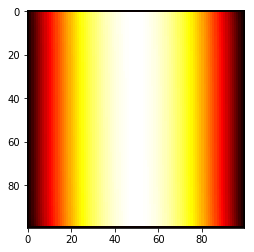

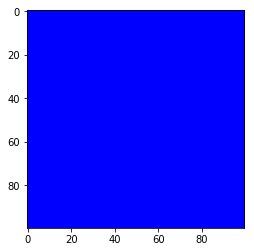

In [8]:
source_func = lambda x,y: 0*x*y+1 # zero source function (multiplication for broadcasting)
phi,s,x,y,b = poisson_2D(source_func,L=1,H=1,num_pts= 100)
# phi,s,x,y,b = poisson_2D(source_func,L=1,H=1,num_pts= 100,BCs = {'n':1,'e':0,'s':1,'w':0})
plt.imshow(phi, cmap='hot')
plt.show()
plt.imshow(s, cmap='winter')
plt.show()
print('b')
print(b)
print("phi")
print(phi)

# Same problem with N_x = N_y = 5 for taking a look at matrices
 Check out the matrices below, which seem to be properly constructed to me

A
[[100. -25.   0. -25.   0.   0.   0.   0.   0.]
 [-25. 100. -25.   0. -25.   0.   0.   0.   0.]
 [  0. -25. 100. -25.   0. -25.   0.   0.   0.]
 [-25.   0. -25. 100. -25.   0. -25.   0.   0.]
 [  0. -25.   0. -25. 100. -25.   0. -25.   0.]
 [  0.   0. -25.   0. -25. 100. -25.   0. -25.]
 [  0.   0.   0. -25.   0. -25. 100. -25.   0.]
 [  0.   0.   0.   0. -25.   0. -25. 100. -25.]
 [  0.   0.   0.   0.   0. -25.   0. -25. 100.]]
b
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
phi
[[0.         0.         0.         0.         0.        ]
 [0.         0.0539759  0.06313253 0.03819277 0.        ]
 [0.         0.04963855 0.06638554 0.04963855 0.        ]
 [0.         0.03819277 0.06313253 0.0539759  0.        ]
 [0.         0.         0.         0.         0.        ]]


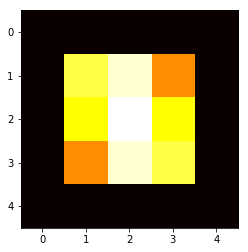

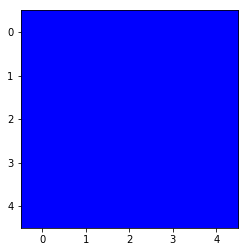

In [9]:
source_func = lambda x,y: 0*x*y+1 # zero source function (multiplication for broadcasting)
phi,s,x,y,b = poisson_2D(source_func,L=1,H=1,num_pts= 5)
# phi,s,x,y,b = poisson_2D(source_func,L=1,H=1,num_pts= 100,BCs = {'n':1,'e':0,'s':1,'w':0})
plt.imshow(phi, cmap='hot')
plt.show()
plt.imshow(s, cmap='winter')
plt.show()
print('b')
print(b)
print("phi")
print(phi)